# 3. Herston model

This notebook implements and evaluates the Heston model, a widely used stochastic volatility model in quantitative finance. The primary focus is to understand how options can be priced under the model's assumptions, and to compare its results with those of simpler models such as Black-Scholes. By incorporating stochastic volatility, the Heston model offers a more realistic framework for capturing features observed in financial markets, such as the volatility smile.

## Goals
- Present the Herston model.
- Compute the option prices using Monte Carlo simulations.
- Calculate key **Greeks**.
- Compare the option pricing in the Black-Scholes with the Herston model.
- Visualize the volatility smile.

## Structure
1. **Model definition**: Present the model and the different parameters.
2. **Monte Carlo simulation**: Explain the discretization scheme and perform some simulations to see the general behaviour.
3. **Model solution**: Compute theoretical prices.
4. **Option pricing**: Price surfaces from Monte Carlo and Carr-Madan schemes.
5. **Conclusion**: Performance analysis and future steps.

## 3.1. Model definition.

The Heston Model, named after Steve Heston, is a type of stochastic volatility model used to price European options. It was presented in 1993 by Steve Heston. In contrast to the Black-Scholes model, where the volatility of the returns is fixed during the market dynamics, in the Herston model it follows a stochastic evolution. This model is able to capture different implied volatility conditions.

Mathematically, the model is defined with the following stochastic equations:

$$
dS_t = r_f S_t dt + \sqrt{\nu _t} S_t dW^{\mathbb{Q}}_S 
$$
$$
d \nu_t = \kappa (\theta - \nu_t) dt + \xi \sqrt{\nu_t} dW^{\mathbb{Q}}_\nu
$$

where:
- $S_t$ is the asset price.
- $\sqrt{\nu_t}$  is the asset volatility
- $\kappa$ is the mean-reverting rate for the volatility
- $\theta$ is the mean-volatility
- The model additionally allows $dW^{\mathbb{Q}}_S$ and $dW^{\mathbb{Q}}_\nu$ to be correlated with correlation $\rho$.

## 3.2. Monte Carlo simulation

In order to perform the simulation of the Heston model, the equations presented before must be discretized. There are different schemes, but here I will follow the Euler-Maruyama method. This method is based on the following integral form of Itô SDE:

$$
X_{t+\Delta t} = X_{t} + \int\limits_{t}^{t+\Delta t}a(X_s, s)ds + \int \limits_{t}^{t+\Delta t}b(X_s, s)dW_s \approx X_t + a(X_t, t) \Delta t + b(X_t, t) \left[W_{t + \Delta t} - W_{t}\right]
$$

For the Heston model, this translates into the following pair of couppled processes:
$$
S_{n+1} = S_{n}\left[1 + r_f \Delta t + \sqrt{\nu_n \Delta t} \xi_1\right]
$$
$$
\nu_{n+1} = \nu_{n} + \kappa(\theta - \nu_t)\Delta t + \sigma  \sqrt{\nu_n \Delta t} \xi_2
$$
where $\xi_1$ and $\xi_2$ are two correlated normal random variables.

This scheme is not completly optimal, as it do not assure that the variance $\nu_n$ remains positive along all the process and can produce some errors if $\nu$ explore values near 0. In such cases, a more complex algorithm should be implemented.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm
import sys
import os
from scipy.optimize import brentq

script_path = os.path.abspath(os.path.join("..", "Scripts"))
if script_path not in sys.path:
    sys.path.append(script_path)

import Heston
import Black_scholes

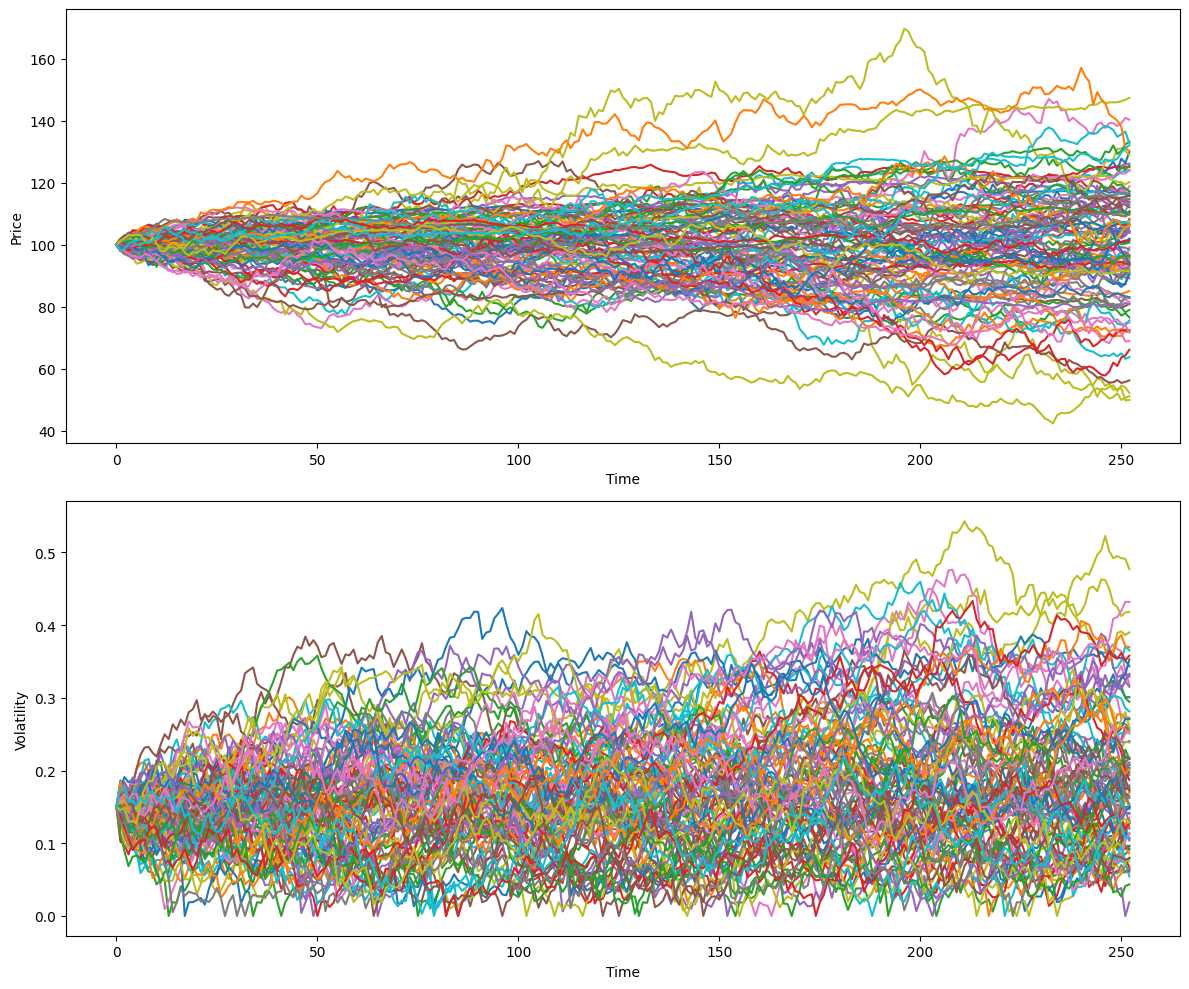

In [2]:
# Example of price path with the Heston model

S0 = 100
v0 = 0.15
kappa = 1.5
theta = 0.06
sigma = 0.4
rho = -0.4
T = 1.0
N = 252
n_simulaciones = 10000
num_trayectorias = 100 #Plotted paths
r = 0.02

precios, vols = Heston.simular_en_paralelo(n_simulaciones, S0, v0, r, kappa, theta, sigma, rho, T, N)

plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
for i in range(num_trayectorias):
    plt.plot(precios[i])
plt.xlabel('Time')
plt.ylabel('Price')

plt.subplot(2, 1, 2)
for i in range(num_trayectorias):
    plt.plot(vols[i])
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.tight_layout()
plt.show()

As it can be seen in the previous plot, although the volatility still follows a continuous path (which no models correctly capture during crisis times), it now follows a random path. This alters the underlying price evolution, leading to more realistic market behavior such as volatility clustering, asymmetric return distributions, and implied volatility skews observed in option markets. Unlike the constant volatility assumption in Black-Scholes, the stochastic nature of volatility in the Heston model allows the asset price to exhibit fatter tails and a more accurate reflection of market uncertainty.

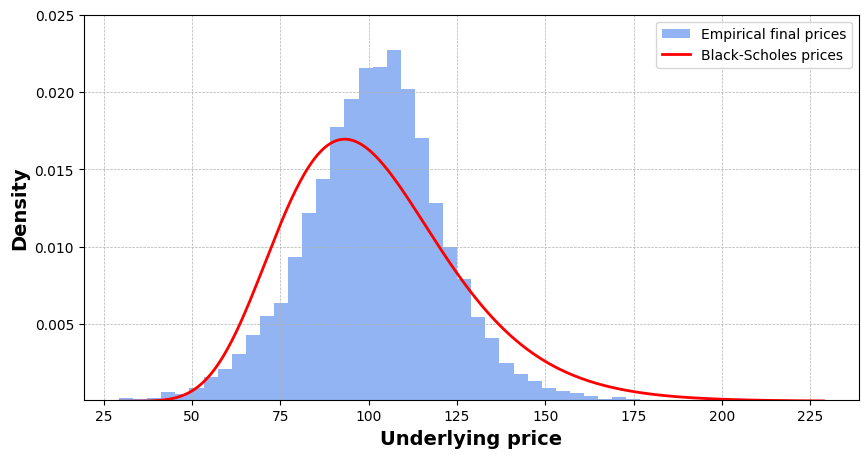

In [3]:
final_prices = precios[:, -1]
final_prices_clean = final_prices[np.isfinite(final_prices)]

plt.figure(figsize=(10, 5))
plt.hist(final_prices_clean, bins=50, density=True, alpha=0.7, color='cornflowerblue', label='Empirical final prices')

x = np.linspace(final_prices_clean.min(), final_prices_clean.max(), 500)
shape = np.sqrt(theta * T)
scale = S0 * np.exp(r * T - 0.5 * np.sqrt(theta)**2 * T) 


pdf = lognorm.pdf(x, s=shape, scale=scale)
plt.ylim(1e-4, 0.025)
plt.plot(x, pdf, 'r-', lw=2, label='Black-Scholes prices')

#plt.yscale('log')
plt.xlabel('Underlying price', fontsize = 14, fontweight = 'bold')
plt.ylabel('Density', fontsize = 14, fontweight = 'bold')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()


## 3.3. Model solution

As in the Black-Scholes framework, we have to derive a SDE to obtain the value of the options.

First, we can start by developing the first terms in the Taylor expansion of $V(S, t)$:

$$
dV = \frac{\partial V}{\partial t}\,dt + \frac{\partial V}{\partial S}\,dS + \frac{\partial V}{\partial \nu}\,d\nu + \frac{1}{2}\frac{\partial ^2 V}{\partial S^2}\,(dS)^2 + \frac{1}{2}\frac{\partial^2 V}{\partial \nu^2} (d\nu)^2+ \frac{1}{2}\,\frac{\partial^2 V}{\partial S \partial \nu}\,dS d\nu
$$

By substitution:

$$
dV = \left[\frac{\partial V}{\partial t} + \frac{1}{2}\nu S^2 \frac{\partial^2 V}{\partial S^2} + \frac{1}{2} \sigma^2\nu \frac{\partial^2 V}{\partial \nu^2} + \rho \sigma \nu S\,\frac{\partial^2 V}{\partial \nu \partial S}+\kappa(\theta-\nu)\,\frac{\partial V}{\partial \nu} + rS\,\frac{\partial V}{\partial S}\right]dt + \frac{\partial V}{\partial S}\,dW_S + \frac{\partial V}{\partial \nu}\,dW_{\nu}
$$

We can now impose that the derivative $V$ grows on average according to the risk-free rate giving the following equation:

$$
\frac{\partial V}{\partial t} + \frac{1}{2}\nu S^2 \frac{\partial^2 V}{\partial S^2} + \frac{1}{2} \sigma^2\nu \frac{\partial^2 V}{\partial \nu^2} + \rho \sigma \nu S\,\frac{\partial^2 V}{\partial \nu \partial S}+\kappa(\theta-\nu)\,\frac{\partial V}{\partial \nu} + rS\,\frac{\partial V}{\partial S} = rV
$$

This equation can be solved in Fourier space given the following price:

$$
C(S, v, t) = S \cdot P_1 - K e^{-r\tau} \cdot P_2
$$

where:
$$
P_j = \frac{1}{2} + \frac{1}{\pi} \int_0^{\infty} \text{Re} \left[ \frac{e^{-i u \ln K} \cdot f_j(u)}{i u} \right] du
\quad \text{with } j = 1, 2
$$

The characteristic funtion $f_j$ is the following:

$$
f_j(u) = \exp\left[ C_j(u, \tau) + D_j(u, \tau) \cdot v + i u \ln S \right]
$$

with

$$
C_j(u, \tau) = r i u \tau + \frac{\kappa \theta}{\sigma^2} \left[ (b_j - \rho \sigma i u + d_j) \tau - 2 \ln \left( \frac{1 - g_j e^{d_j \tau}}{1 - g_j} \right) \right]
$$
$$
D_j(u, \tau) = \frac{b_j - \rho \sigma i u + d_j}{\sigma^2} \cdot \left( \frac{1 - e^{d_j \tau}}{1 - g_j e^{d_j \tau}} \right)
$$

where
$$
d_j = \sqrt{ (\rho \sigma i u - b_j)^2 + \sigma^2 (i u + u^2) }
$$
$$
g_j = \frac{b_j - \rho \sigma i u + d_j}{b_j - \rho \sigma i u - d_j}
$$

The parameters $b_j$ depends on the index $j$:

$$
b_1 = \kappa - \rho \sigma, \quad b_2 = \kappa
$$

## 3.4. Option pricing

For an European vanilla option, the price can be easily computed at the maturity time. For example, for an European call option:

$$
C(t=T, K) = \mathbb{E}\left[(S_T - K)^{+}\right] 
$$

In order to compute then the price of that option today, we should discount the payoff given by the free-rate growth. Thus:
$$
C(T, K | t=0) = e^{-r_f\,T} \cdot  \mathbb{E}\left[(S_T - K)^{+}\right] 
$$

In adition to the already computed analytical solution, the Monte Carlo scheme allows us to valuate the expected value part of the option and then compute the discounted payoff.

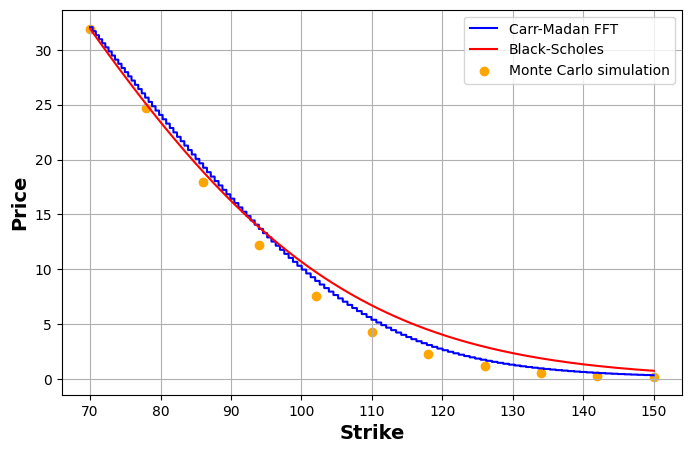

In [4]:
def Implied_Volatility(precio_objetivo, S, K, r, T, option_type = 'call'):
    try:
        iv = brentq(
            lambda sigma: Black_scholes.Black_Scholes_pricing(T, K, S, r, sigma, option_type) - precio_objetivo,
            1e-6, 3.0  
        )
        return iv
    except ValueError:
        return np.nan 
    
precios, strikes = Heston.heston_option_prices_smile(S0, T, r, v0, kappa, theta, sigma, rho)
strikes2, precios2 = Heston.heston_fft_prices(S0, T, kappa, rho, sigma,theta, v0*v0, r, strike_range=(0.7 * S0, 1.5 * S0)) 

precios_BS = Black_scholes.Black_Scholes_pricing(T, strikes2, S0, r, np.sqrt(theta), option_type='call')

plt.figure(figsize=(8, 5))
plt.plot(strikes2, precios2, color = 'blue', label = 'Carr-Madan FFT')
plt.plot(strikes2, precios_BS, color = 'red', label = 'Black-Scholes')
plt.scatter(strikes, precios, color = 'orange', label = 'Monte Carlo simulation')

plt.xlabel('Strike', fontsize=14, fontweight='bold')
plt.ylabel('Price', fontsize=14, fontweight='bold')
plt.grid(True)
plt.legend()
plt.show()

As observed in the plot, the **Black-Scholes model** tends to produce:

- **Overvalued in-the-money (ITM) option prices**
- **Undervalued out-of-the-money (OTM) option prices**

Although real market prices do not necessarily follow the Heston model exactly, this behavior often manifests in practice. Consequently, pricing options solely with the **Black-Scholes model**, which assumes constant volatility, introduces systematic mispricings. Traders who recognize and exploit this edge can gain an advantage.

This highlights the importance of incorporating stochastic volatility and volatility smiles in option pricing and risk management.

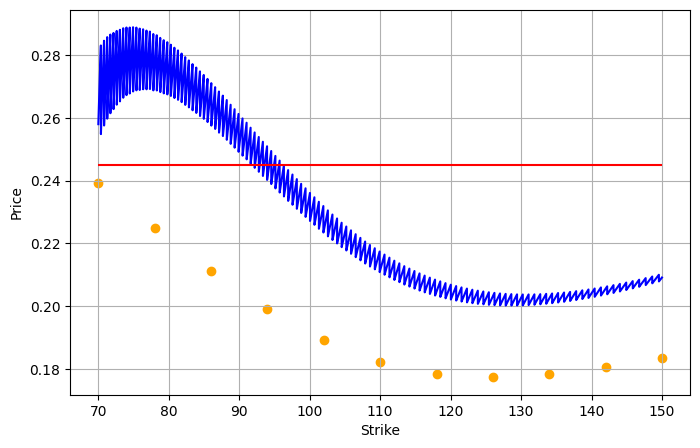

In [8]:
vols_implícitas = []
for price, K in zip(precios, strikes):
    iv = Implied_Volatility(price, S0, K, r, T, option_type='call')
    vols_implícitas.append(iv)

vols_implícitas2 = []
for i, K in enumerate(strikes2):
    iv = Implied_Volatility(precios2[i], S0, K, r, T, option_type= 'call')
    vols_implícitas2.append(iv)

plt.figure(figsize=(8, 5))
plt.scatter(strikes, vols_implícitas, color = 'orange')
plt.plot(strikes2, vols_implícitas2, color = 'blue')
plt.hlines(np.sqrt(theta), xmin=strikes2.min(), xmax=strikes2.max(), colors='red')

plt.xlabel('Strike')
plt.ylabel('Price')
plt.grid(True)
plt.show()

However, as the relation between the prices and the volatility is not linear, a reasonable good agreement between Monte Carlo and Carr-Madan prices do not guarantee that the implied volatility is well reproduced. However, the general shape of the volatility is captured.

## Conclusion

In this notebook, we explored the Heston model, a stochastic volatility model that extends the classical Black-Scholes framework by allowing volatility to vary over time. Although more complex, the Heston model offers a more realistic representation of market behavior, particularly in capturing empirical phenomena such as the volatility smile and skew, which are not adequately addressed by the constant volatility assumption in Black-Scholes.

As a next step, this model can be calibrated using observed option prices or implied volatilities from the market. 